# 0.0. IMPORTS

In [7]:
import math 
import inflection

import pandas as pd 
import numpy as np
import seaborn as sns 

from matplotlib import pyplot as plt 
from IPython.core.display import HTML

## 0.1. Load Data

In [11]:
data_sales_raw = pd.read_csv('data/train.csv')
data_store_raw = pd.read_csv('data/store.csv')

df_raw = pd.merge(data_sales_raw, data_store_raw, how = 'left', on ='Store')

C:\Users\bruni\AppData\Local\Temp\ipykernel_15672\2795723657.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  data_sales_raw = pd.read_csv('data/train.csv')


# 1.0. DATA DESCRIPTION

In [13]:
df1 = df_raw.copy()

## 1.1 Rename columns 

In [14]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [20]:
old_cols = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x : inflection.underscore(x)

new_cols = list(map(snakecase, old_cols))

df1.columns = new_cols

In [22]:
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2. Data Dimensions

In [23]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 1017209
Number of Cols: 18


## 1.3. Data Types

In [24]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [25]:
df1['date'] = pd.to_datetime(df1['date'])

## 1.4. Check NULL Data

In [28]:
df1.isnull().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NULL Data

### 1.5.1. competition_distance

In [59]:
print('Max : {}'.format(df1['competition_distance'].max()))
print('Min : {}'.format(df1['competition_distance'].min()))
df1.competition_distance.describe()

Max : 75860.0
Min : 20.0


count    1.014567e+06
mean     5.430086e+03
std      7.715324e+03
min      2.000000e+01
25%      7.100000e+02
50%      2.330000e+03
75%      6.890000e+03
max      7.586000e+04
Name: competition_distance, dtype: float64

In [60]:
df1['competition_distance'] = df1['competition_distance'].apply(
    lambda x : 150000.0 if np.isnan(x) else x
)

### 1.5.2. competition_open_since

In [66]:
df1['competition_open_since_month'] = df1.apply(
    lambda x : x['date'].month if np.isnan(x['competition_open_since_month']) else
    x['competition_open_since_month'], axis = 1 
)

In [68]:
df1['competition_open_since_year'] = df1.apply(
    lambda x : x['date'].year if np.isnan(x['competition_open_since_year']) else
    x['competition_open_since_year'], axis = 1 
)

### 1.5.3. promo

In [70]:
df1['promo2_since_week'] = df1.apply( lambda x: x['date'].week if math.isnan(
x['promo2_since_week'] ) else x['promo2_since_week'], axis=1 )

In [71]:
df1['promo2_since_year'] = df1.apply( lambda x: x['date'].year if math.isnan(
x['promo2_since_year'] ) else x['promo2_since_year'], axis=1 )

In [73]:
df1['promo_interval'].fillna(0, inplace = True)

### 1.5.4. Creating new columns

In [74]:
month_map = {1: 'Jan', 2: 'Feb', 3:'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

df1['month_map'] = df1['date'].dt.month.map(month_map)

In [75]:
df1['is_promo'] = df1[['promo_interval', 'month_map']].apply( 
        lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] 
        in x['promo_interval'].split( ',' ) else 0, axis=1 )

## 1.6. Change Data Types

In [94]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)

df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)

df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [99]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 20 columns):
 #   Column                        Non-Null Count    Dtype         
---  ------                        --------------    -----         
 0   store                         1017209 non-null  int64         
 1   day_of_week                   1017209 non-null  int64         
 2   date                          1017209 non-null  datetime64[ns]
 3   sales                         1017209 non-null  int64         
 4   customers                     1017209 non-null  int64         
 5   open                          1017209 non-null  int64         
 6   promo                         1017209 non-null  int64         
 7   state_holiday                 1017209 non-null  object        
 8   school_holiday                1017209 non-null  int64         
 9   store_type                    1017209 non-null  object        
 10  assortment                    1017209 non-null  object        
 11

## 1.7. Descriptive Statistics

In [107]:
cat_attributes = df1.select_dtypes(exclude= ['int64', 'float64', 'int32', 'datetime64[ns]'])
num_attributes = df1.select_dtypes(include= ['int64', 'float64', 'int32'])

### 1.7.1. Numerical Attributes

In [108]:
mean_ = pd.DataFrame(num_attributes.apply(np.mean)).T
median_ = pd.DataFrame(num_attributes.apply(np.median)).T

std_ = pd.DataFrame( num_attributes.apply( np.std ) ).T
min_ = pd.DataFrame( num_attributes.apply( min ) ).T
max_ = pd.DataFrame( num_attributes.apply( max ) ).T
range_ = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T
skew_ = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T
kurtosis_ = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T

m = pd.concat( [min_, max_, range_, mean_, median_, std_, skew_, kurtosis_] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

In [109]:
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,150000.0,149980.0,5805.577526,2330.0,10654.360026,7.492361,88.374150
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


### 1.7.2. Categorical Attributes

In [110]:
cat_attributes.apply( lambda x: x.unique().shape[0])

state_holiday      5
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<Axes: xlabel='assortment', ylabel='sales'>

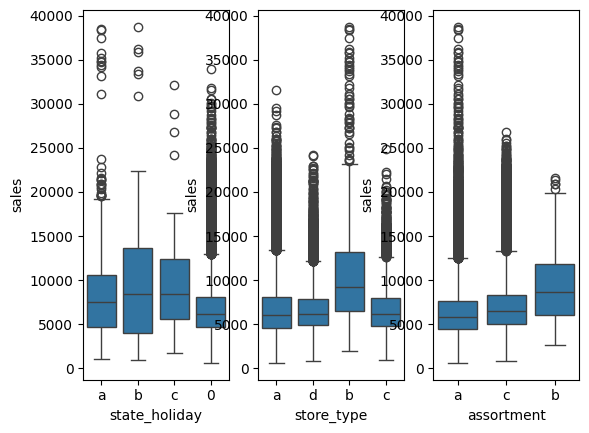

In [111]:
aux = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

plt.subplot( 1, 3, 1 )
sns.boxplot( x='state_holiday', y='sales', data=aux )

plt.subplot( 1, 3, 2 )
sns.boxplot( x='store_type', y='sales', data=aux )

plt.subplot( 1, 3, 3 )
sns.boxplot( x='assortment', y='sales', data=aux )

# 2.0 AA